In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

#!pip install https://github.com/Phlya/adjustText/archive/master.zip
from adjustText import adjust_text

#pd.set_option('display.max_rows', None) # don't limit the number of rows in printouts of dataframes
#pd.set_option('display.max_seq_items', None)
#pd.set_option('display.large_repr', 'truncate')


# Read in data and do basic massaging

In [2]:
df_us_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
df_us_raw.head(2)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,133,133,133,133,135,135,136,136,136,136


In [3]:
df_us_raw.groupby(['Country_Region']).sum().loc[:,'4/4/20']

Country_Region
US    308853
Name: 4/4/20, dtype: int64

In [4]:
df_global_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_global_raw.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,555,607,665,714,784,840,906,933,996,1026
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,433,446,467,475,494,518,539,548,562,584


In [5]:
df_global_raw.groupby(['Country/Region']).sum().loc['US',:]

Lat            37.0902
Long          -95.7129
1/22/20         1.0000
1/23/20         1.0000
1/24/20         2.0000
              ...     
4/16/20    667592.0000
4/17/20    699706.0000
4/18/20    732197.0000
4/19/20    759086.0000
4/20/20    784326.0000
Name: US, Length: 92, dtype: float64

In [6]:
# change the value of 'US' to 'United States' so that
# it is different from the df_us_raw file so we don't
# double count
df_global_raw = df_global_raw.set_index('Country/Region')
as_list = df_global_raw.index.tolist()
idx = as_list.index('US')
as_list[idx] = 'United States'
df_global_raw.index = as_list
print(df_global_raw.loc['United States'])
df_global_raw = df_global_raw.reset_index()
df_global_raw.rename(columns={'index': 'Country/Region'}, inplace=True)

Province/State        NaN
Lat               37.0902
Long             -95.7129
1/22/20                 1
1/23/20                 1
                   ...   
4/16/20            667592
4/17/20            699706
4/18/20            732197
4/19/20            759086
4/20/20            784326
Name: United States, Length: 93, dtype: object


In [7]:

print(df_us_raw.columns)
print(df_global_raw.columns)

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '4/11/20', '4/12/20', '4/13/20', '4/14/20', '4/15/20', '4/16/20',
       '4/17/20', '4/18/20', '4/19/20', '4/20/20'],
      dtype='object', length=101)
Index(['Country/Region', 'Province/State', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/

In [8]:
#df_us_raw.Combined_Key.unique()

In [9]:
df_global_raw = df_global_raw.rename(columns={'Province/State': 'Province_State', 
                                             'Country/Region': 'Country_Region',
                                             'Long': 'Long_'})
#df_global_raw['Combined_Key'] = df_global_raw.Province_State.astype(str).str.cat(df_global_raw.Country_Region.astype(str), sep=', ', na_rep='')
df_global_raw.insert(loc=4, column='Combined_Key', value=df_global_raw.Province_State.astype(str).str.cat(df_global_raw.Country_Region.astype(str), sep=', ', na_rep=''))


df_raw = df_global_raw.append(df_us_raw)
df_raw

,Country_Region,Province_State,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,4/17/20,4/18/20,4/19/20,4/20/20,UID,iso2,iso3,code3,FIPS,Admin2
0,Afghanistan,NaN,33.000000,65.000000,"nan, Afghanistan",0,0,0,0,0,...,906,933,996,1026,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,NaN,41.153300,20.168300,"nan, Albania",0,0,0,0,0,...,539,548,562,584,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,NaN,28.033900,1.659600,"nan, Algeria",0,0,0,0,0,...,2418,2534,2629,2718,NaN,NaN,NaN,NaN,NaN,NaN
3,Andorra,NaN,42.506300,1.521800,"nan, Andorra",0,0,0,0,0,...,696,704,713,717,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,NaN,-11.202700,17.873900,"nan, Angola",0,0,0,0,0,...,19,24,24,24,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3256,US,Utah,39.372319,-111.575868,"Central Utah, Utah, US",0,0,0,0,0,...,0,0,15,17,84070016.0,US,USA,840.0,NaN,Central Utah
3257,US,Utah,38.996171,-110.701396,"Southeast Utah, Utah, US",0,0,0,0,0,...,0,0,6,7,84070017.0,US,USA,840.0,NaN,Southeast Utah
3258,US,Utah,37.854472,-111.441876,"Southwest Utah, Utah, US",0,0,0,0,0,...,0,0,66,70,84070018.0,US,USA,840.0,NaN,Southwest Utah
3259,US,Utah,40.124915,-109.517442,"TriCounty, Utah, US",0,0,0,0,0,...,0,0,10,10,84070019.0,US,USA,840.0,NaN,TriCounty


In [10]:
#df_global_raw.Combined_Key.unique()

In [11]:
df_raw.Country_Region.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [12]:
df_raw = df_raw.drop(labels=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2'], axis=1)

In [13]:
df_raw.columns

Index(['Country_Region', 'Province_State', 'Lat', 'Long_', 'Combined_Key',
       '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20',
       '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20',
       '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20',
       '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20',
       '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20',
       '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20',
       '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20',
       '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20',
       '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20',
       '3/31/20', '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20',
       '4/7/20', '4/8/20', '4

In [14]:
#df_raw['Country_Region'].unique()

In [15]:
#df_raw['Province_State'].unique()

In [16]:
tempdf = df_raw.groupby('Country_Region').sum()
tempdf.sort_values(by=tempdf.columns[-1]).iloc[:,[-1]].tail(15)

,4/20/20
Country_Region,
Netherlands,33588
Canada,37657
Belgium,39983
Brazil,40743
Russia,47121
Iran,83505
China,83817
Turkey,90980
United Kingdom,125856


In [17]:
df1 = df_raw.melt(id_vars=df_raw.columns[:5], var_name='Date', value_name='Confirmed')
df1 = df1.set_index('Date')
df1

,Country_Region,Province_State,Lat,Long_,Combined_Key,Confirmed
Date,,,,,,
1/22/20,Afghanistan,NaN,33.000000,65.000000,"nan, Afghanistan",0
1/22/20,Albania,NaN,41.153300,20.168300,"nan, Albania",0
1/22/20,Algeria,NaN,28.033900,1.659600,"nan, Algeria",0
1/22/20,Andorra,NaN,42.506300,1.521800,"nan, Andorra",0
1/22/20,Angola,NaN,-11.202700,17.873900,"nan, Angola",0
...,...,...,...,...,...,...
4/20/20,US,Utah,39.372319,-111.575868,"Central Utah, Utah, US",17
4/20/20,US,Utah,38.996171,-110.701396,"Southeast Utah, Utah, US",7
4/20/20,US,Utah,37.854472,-111.441876,"Southwest Utah, Utah, US",70


In [18]:
df2 = df_raw.melt(id_vars='Combined_Key', value_vars=df_raw.columns[5:], var_name='Date', value_name='Confirmed')
df2['Date'] = pd.to_datetime(df2.Date)
df2 = df2.set_index('Date')
df2

,Combined_Key,Confirmed
Date,,
2020-01-22,"nan, Afghanistan",0
2020-01-22,"nan, Albania",0
2020-01-22,"nan, Algeria",0
2020-01-22,"nan, Andorra",0
2020-01-22,"nan, Angola",0
...,...,...
2020-04-20,"Central Utah, Utah, US",17
2020-04-20,"Southeast Utah, Utah, US",7
2020-04-20,"Southwest Utah, Utah, US",70


# Narrow down to a set of interesting States and Counties and graph

In [19]:
# just a cell to try different approaches for choosing rows
rowsofinterest = df2['Combined_Key'].isin(['Santa Clara, California, US', 'New York City, New York, US', 'Salt Lake, Utah, US'])
rowsofinterest = df2['Combined_Key'].str.endswith('California, US')
df2.loc[rowsofinterest,:].head(2)

,Combined_Key,Confirmed
Date,,
2020-01-22,"Alameda, California, US",0
2020-01-22,"Alpine, California, US",0


In [20]:
df = pd.DataFrame(index = df2.index.unique(),
                     data = {
                         'California': df2.loc[df2['Combined_Key'].str.endswith('California, US'),'Confirmed'].groupby(level=0).sum(),
                         'New York': df2.loc[df2['Combined_Key'].str.endswith('New York, US'),'Confirmed'].groupby(level=0).sum(),
                         'Washington': df2.loc[df2['Combined_Key'].str.endswith('Washington, US'),'Confirmed'].groupby(level=0).sum(),
                         'Utah': df2.loc[df2['Combined_Key'].str.endswith('Utah, US'),'Confirmed'].groupby(level=0).sum(),
                         'Hawaii': df2.loc[df2['Combined_Key'].str.endswith('Hawaii, US'),'Confirmed'].groupby(level=0).sum(),
                         'Idaho': df2.loc[df2['Combined_Key'].str.endswith('Idaho, US'),'Confirmed'].groupby(level=0).sum(),
                         'Texas': df2.loc[df2['Combined_Key'].str.endswith('Texas, US'),'Confirmed'].groupby(level=0).sum(),
                         'Santa Clara Co.': df2.loc[df2['Combined_Key']=='Santa Clara, California, US', 'Confirmed'].groupby(level=0).sum(),
                         #'Los Angeles Co.': df2.loc[df2['Combined_Key']=='Los Angeles, California, US', 'Confirmed'].groupby(level=0).sum(),
                         'Japan': df2.loc[df2['Combined_Key'].str.endswith('Japan'),'Confirmed'].groupby(level=0).sum(),
                         # note that in the following, we are using 'United States' which is the renamed country
                         # value from the global file so that we don't double count
                         'United States': df2.loc[df2['Combined_Key'].str.endswith('United States'),'Confirmed'].groupby(level=0).sum(),
                         'Singapore': df2.loc[df2['Combined_Key'].str.endswith('Singapore'),'Confirmed'].groupby(level=0).sum(),
                         'Italy': df2.loc[df2['Combined_Key'].str.endswith('Italy'),'Confirmed'].groupby(level=0).sum(),
                         'Spain': df2.loc[df2['Combined_Key'].str.endswith('Spain'),'Confirmed'].groupby(level=0).sum(),
                         'Iran': df2.loc[df2['Combined_Key'].str.endswith('Iran'),'Confirmed'].groupby(level=0).sum(),
                         'France': df2.loc[df2['Combined_Key'].str.endswith('France'),'Confirmed'].groupby(level=0).sum(),
                         'Germany': df2.loc[df2['Combined_Key'].str.endswith('Germany'),'Confirmed'].groupby(level=0).sum(),
                         'Switzerland': df2.loc[df2['Combined_Key'].str.endswith('Switzerland'),'Confirmed'].groupby(level=0).sum(),
                         'United Kingdom': df2.loc[df2['Combined_Key'].str.endswith('United Kingdom'),'Confirmed'].groupby(level=0).sum(),
                         'South Korea': df2.loc[df2['Combined_Key'].str.endswith('Korea, South'),'Confirmed'].groupby(level=0).sum(),
       #                  'Taiwan': df2.loc[df2['Combined_Key'].str.endswith('Taiwan*'),'Confirmed'].groupby(level=0).sum(),
       #                  'Philippines': df2.loc[df2['Combined_Key'].str.endswith('Philippines'),'Confirmed'].groupby(level=0).sum(),
       #                  'Ireland': df2.loc[df2['Combined_Key'].str.endswith('Ireland'),'Confirmed'].groupby(level=0).sum(),
                         'China': df2.loc[df2['Combined_Key'].str.endswith('China'),'Confirmed'].groupby(level=0).sum(),
                         'Turkey': df2.loc[df2['Combined_Key'].str.endswith('Turkey'),'Confirmed'].groupby(level=0).sum(),
       #                  'Belgium': df2.loc[df2['Combined_Key'].str.endswith('Belgium'),'Confirmed'].groupby(level=0).sum(),
       #                  'Netherlands': df2.loc[df2['Combined_Key'].str.endswith('Netherlands'),'Confirmed'].groupby(level=0).sum(),
                         'Canada': df2.loc[df2['Combined_Key'].str.endswith('Canada'),'Confirmed'].groupby(level=0).sum(),
                         'Brazil': df2.loc[df2['Combined_Key'].str.endswith('Brazil'),'Confirmed'].groupby(level=0).sum(),
                     }

)
df = df.loc[~(df==0).all(axis=1)] # drop rows with all zeros
# The next two drops ensure that if the two source files are out of sync, we don't
# show the rows where there is zero data for one of them
df = df.loc[~(df['Italy']==0)] # drop rows if Italy is Zero (from global source)
df = df.loc[~(df['California']==0)] # drop rows if California is Zero (from US source)
df = df.loc['2/1/20':,:]
df

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,China,Turkey,Canada,Brazil
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,3,0,1,0,0,0,0,1,20,8,...,0,6,8,0,2,12,11891,0,4,0
2020-02-02,3,0,1,0,0,0,0,1,20,8,...,0,6,10,0,2,15,16630,0,4,0
2020-02-03,6,0,1,0,0,0,0,2,20,11,...,0,6,12,0,2,15,19716,0,4,0
2020-02-04,6,0,1,0,0,0,0,2,22,11,...,0,6,12,0,2,16,23707,0,4,0
2020-02-05,6,0,1,0,0,0,0,2,22,11,...,0,6,12,0,2,19,27440,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-16,27677,223691,11057,2528,530,1587,16876,1833,8626,667592,...,77995,147091,137698,26732,104145,10613,83403,74193,30808,30425
2020-04-17,29157,230597,11517,2609,541,1609,17849,1870,9787,699706,...,79494,149130,141397,27078,109769,10635,83760,78546,32813,33682
2020-04-18,30491,241712,11776,2728,574,1655,18704,1870,10296,732197,...,80868,149149,143342,27404,115314,10653,83787,82329,34355,36658


In [21]:
df['United States']

Date
2020-02-01         8
2020-02-02         8
2020-02-03        11
2020-02-04        11
2020-02-05        11
               ...  
2020-04-16    667592
2020-04-17    699706
2020-04-18    732197
2020-04-19    759086
2020-04-20    784326
Name: United States, Length: 80, dtype: int64

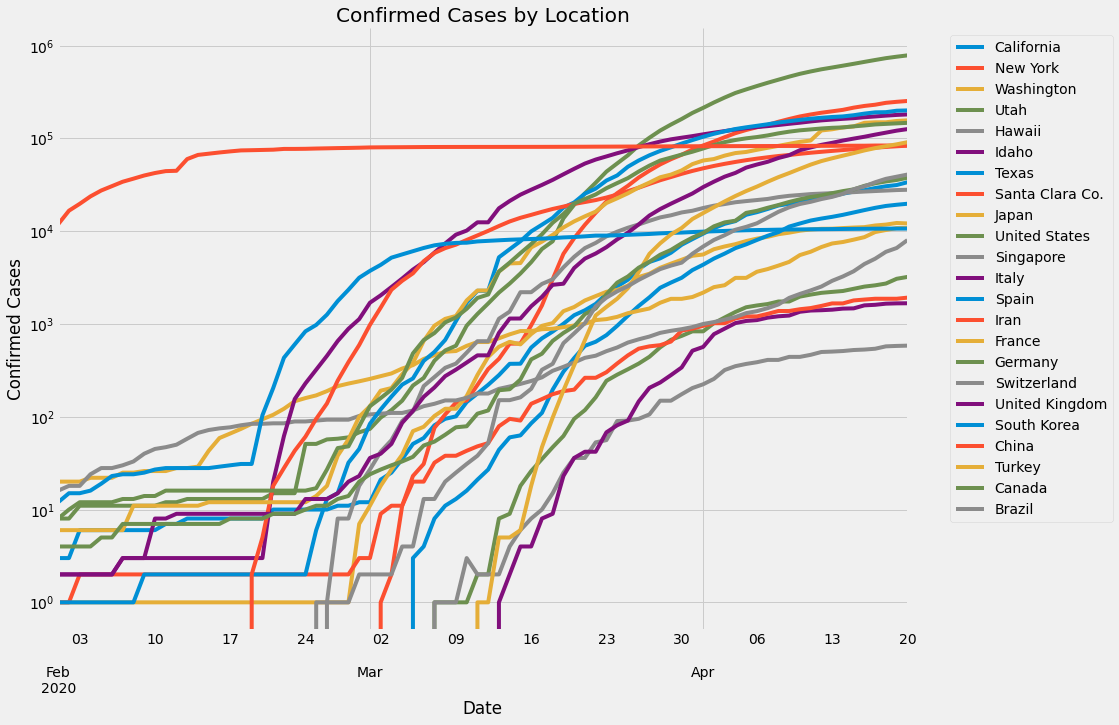

In [22]:
#newdf.loc['2/1/20':,:].plot(logy=True)
df.plot(logy=True)
plt.legend(bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.title("Confirmed Cases by Location")
plt.ylabel("Confirmed Cases")
sns.despine()

# TEMP ONLY
Drop rows that have data glitches

In [23]:
#df = df.drop(labels=['3/22/20', '3/30/20'], axis=0)

# Graph raw data

### label_lines routine

In [24]:
def label_lines(df, ax, tuple_selector=None, print_value=False, font_family='sans-serif', font_size=14):
    '''Labels lines in a chart assuming that some lines will be different lengths than others
       If tuple_selector is set to an integer, use it as an index to the label'''
    texts = []
    for label, series in df.items():
        prev_x = series.index[0]
        prev_data = series.iloc[0]
        for index, data in series.items():
            if pd.isnull(data):
                break
            prev_x = index
            prev_data = data
        if not (tuple_selector is None):
            if print_value:
                label = '{} ({:,})'.format(label[tuple_selector], int(prev_data))
            else:
                label = label[tuple_selector]
        else:
            if print_value:
                label = '{} ({:,})'.format(label, int(prev_data))
        this_annotation = ax.annotate(label, (prev_x, prev_data),
                            xytext=(10,0), 
                            textcoords='offset pixels',
                            family=font_family, fontsize=font_size, color='darkslategrey')
        texts.append(this_annotation)
    #adjust_text(texts)

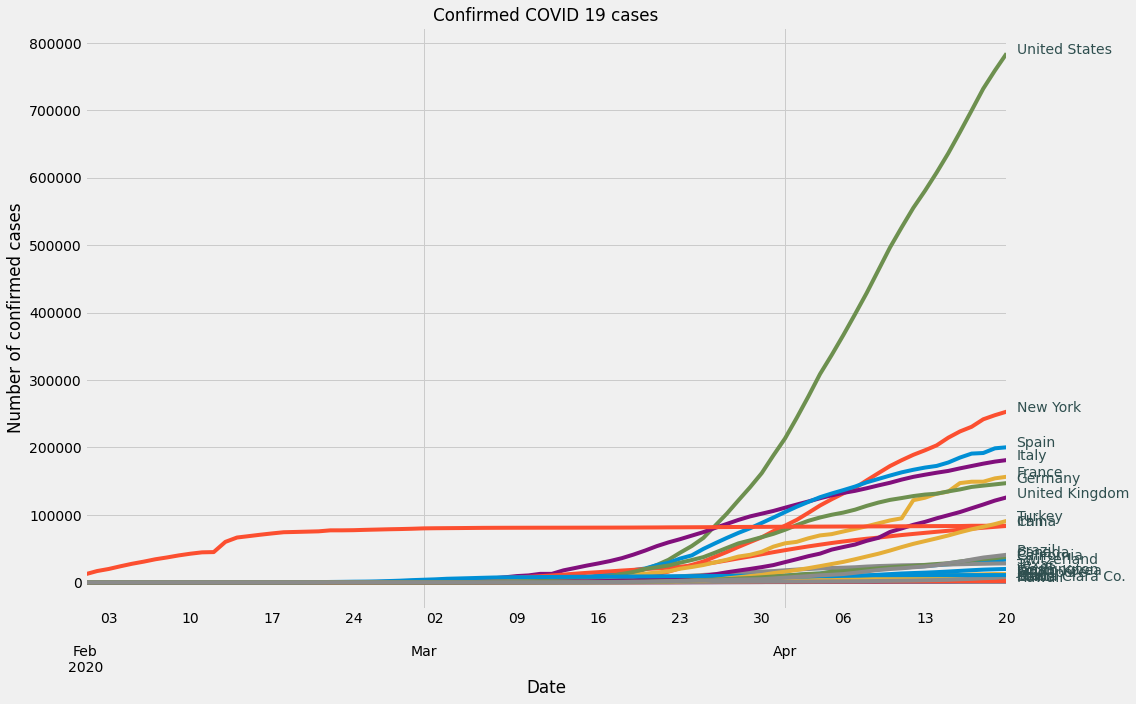

In [25]:
  
graph_data = df.loc['2020-02':,:]
#graph_data = df.drop('China', axis=1).loc['2/21/20':,:]
ax = graph_data.plot(legend=False)
ax.set_title('Confirmed COVID 19 cases', fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')
label_lines(graph_data, ax)
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig('raw.png')

# Create a 'days since 100 cases' graph

In [26]:
df.tail(2)

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,China,Turkey,Canada,Brazil
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-19,31431,247815,12255,3069,580,1668,19260,1870,10797,759086,...,82211,154097,145184,27740,121172,10661,83805,86306,35632,38654
2020-04-20,33686,253060,12114,3213,584,1672,19751,1922,10797,784326,...,83505,156480,147065,27944,125856,10674,83817,90980,37657,40743


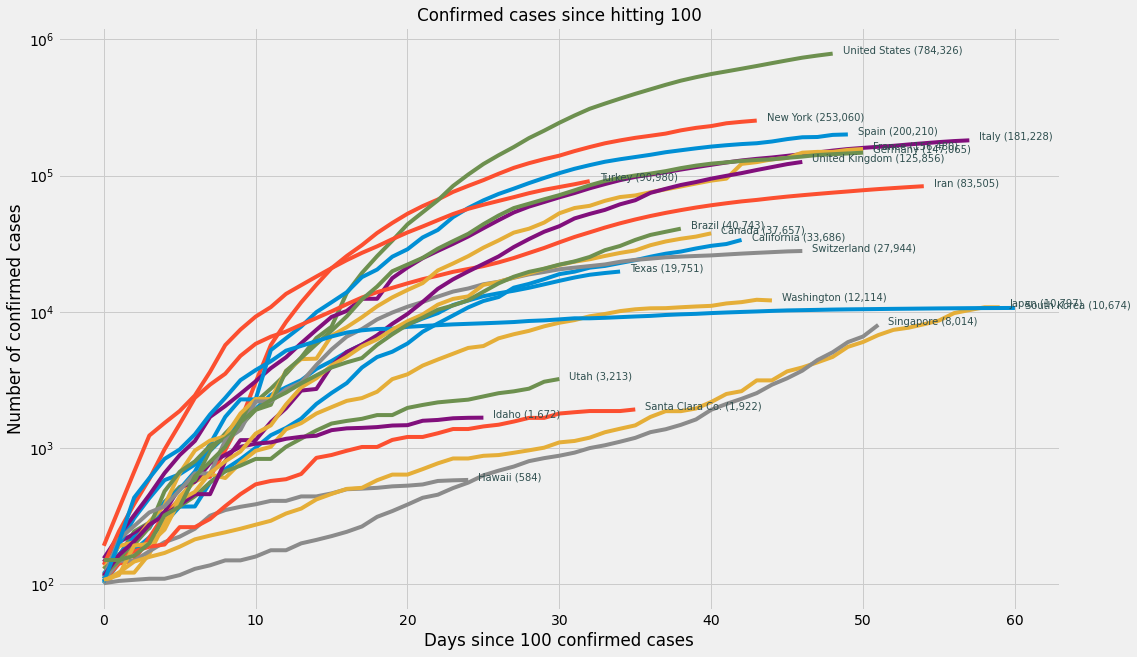

In [27]:
threshold = 100
daysSince100 = pd.DataFrame(index=range(0,len(df.index)))
for location in df.columns:
    # create list of data once above 'threshold'
    tempList = [df.loc[date, location] 
                              for date in df[location].index 
                              if df.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSince100.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSince100[location] = tempListFilled

daysSince100 = daysSince100.drop('China', axis=1)
daysSince100 = daysSince100.dropna(axis=0, how='all')
ax = daysSince100.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Confirmed cases since hitting {}'.format(threshold), fontsize='large')
ax.set_xlabel('Days since {} confirmed cases'.format(threshold), fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')
#ax.annotate("Italy on 3/14", xy=(20,21157), xytext=(15, 30000),
#            arrowprops=dict(facecolor='grey', shrink=0.05),)

label_lines(daysSince100, ax, print_value=True, font_size=10)
    
#ax.hlines(60461826, 0, 50, linestyles='dotted', label='Pop of Italy')
plt.show()
fig = ax.get_figure()
fig.savefig('since100.png')

# Cases relative to Population

In [28]:
per = 100000

popdf = pd.DataFrame(index = df.index,
                     data = {
                         'California': 39747267,
                         'New York': 19491339,
                         'Washington': 7797095,
                         'Utah': 3282115,
                         'Hawaii': 1412687,
                         'Idaho': 1826156,
                         'Texas': 29472295,
                         'Santa Clara Co.': 2200000,
                         'Los Angeles Co.': 10500000,
                         'Japan': 126476461,
                         'United States': 331002651,
                         'Singapore': 5850342,
                         'Italy': 60461826,
                         'Spain': 46754778,
                         'Iran': 83992949,
                         'France': 65273511,
                         'Germany': 83783942,
                         'Switzerland': 8654622,
                         'United Kingdom': 67886011,
                         'South Korea': 51269185,
                         'Taiwan': 23816775,
                         'Philippines': 109581078,
                         'Ireland': 4937786,
                         'China': 1439323776,
                         'Turkey': 84339067,
                         'Belgium': 11589623,
                         'Netherlands': 17134872,
                         'Canada': 37742154,
                         'Brazil': 212559417,
                         'India': 1380004385,
                         'Indonesia': 273523615,
                         'Pakistan': 220892340,
                         'Nigeria': 206139589,
                         
                     }

)
popdf

casesperdf = df.div(popdf).mul(per)
casesperdf.tail()

,Belgium,Brazil,California,Canada,China,France,Germany,Hawaii,Idaho,India,...,South Korea,Spain,Switzerland,Taiwan,Texas,Turkey,United Kingdom,United States,Utah,Washington
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-16,NaN,14.313645,69.632461,81.627562,5.794596,225.345623,164.348915,37.517157,86.903857,NaN,...,20.700544,395.570267,308.875419,NaN,57.260556,87.969908,153.411577,201.687811,77.023505,141.809225
2020-04-17,NaN,15.845922,73.355987,86.939924,5.819399,228.469402,168.763843,38.295815,88.108573,NaN,...,20.743454,408.170048,312.873283,NaN,60.561962,93.131218,161.696053,211.389848,79.491425,147.708858
2020-04-18,NaN,17.246001,76.712193,91.025541,5.821275,228.498510,171.085290,40.631789,90.627526,NaN,...,20.778563,410.067181,316.640057,NaN,63.462991,97.616683,169.864157,221.205781,83.117136,151.030608
2020-04-19,NaN,18.185033,79.077135,94.409026,5.822526,236.078920,173.283802,41.056511,91.339404,NaN,...,20.794167,424.927694,320.522375,NaN,65.349509,102.332173,178.493328,229.329281,93.506778,157.173922
2020-04-20,NaN,19.167817,84.750481,99.774380,5.823360,239.729712,175.528862,41.339660,91.558443,NaN,...,20.819523,428.212920,322.879497,NaN,67.015480,107.874089,185.393129,236.954598,97.894193,155.365556


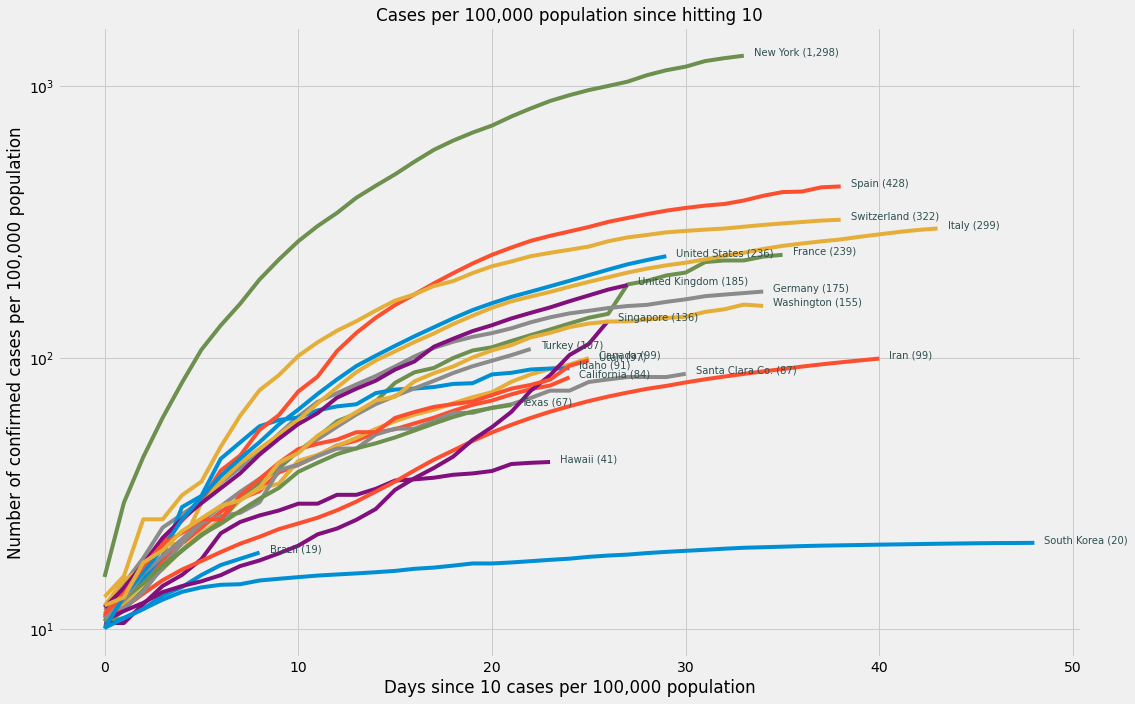

In [29]:
threshold = 10
daysSincerate = pd.DataFrame(index=range(0,len(casesperdf.index)))
for location in casesperdf.columns:
    # create list of data once above 'threshold'
    tempList = [casesperdf.loc[date, location] 
                              for date in casesperdf[location].index 
                              if casesperdf.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSincerate.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSincerate[location] = tempListFilled


#daysSincerate = daysSincerate.drop(['China','Singapore'], axis=1)
daysSincerate = daysSincerate.dropna(axis=0, how='all')
ax = daysSincerate.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Cases per {:,} population since hitting {}'.format(per, threshold), fontsize='large')
ax.set_xlabel('Days since {} cases per {:,} population'.format(threshold, per), fontsize='large')
ax.set_ylabel('Number of confirmed cases per {:,} population'.format(per), fontsize='large')
#ax.annotate("Italy on 3/14", xy=(16,34.99), xytext=(25, 24),
#            arrowprops=dict(facecolor='grey', shrink=0.05),)

label_lines(daysSincerate, ax, print_value=True, font_size=10)

plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig('pop-adjusted.png')

In [30]:
daysSincerate

,Brazil,California,Canada,France,Germany,Hawaii,Idaho,Iran,Italy,New York,...,Singapore,South Korea,Spain,Switzerland,Texas,Turkey,United Kingdom,United States,Utah,Washington
0,10.440375,11.716529,10.709511,10.238456,11.048657,10.547276,11.225766,10.715185,12.197779,15.586410,...,10.785694,10.115238,11.190300,13.160598,10.677825,10.928506,12.026042,10.053092,11.395091,12.248151
1,11.022800,12.818491,12.405227,11.819496,14.712843,10.547276,12.813801,11.995054,15.169902,29.264280,...,11.674531,10.963701,13.669191,15.702592,12.924002,12.837467,14.200275,13.245513,13.497394,13.107446
2,11.884677,14.723025,14.773932,13.978105,18.285127,12.387741,15.387513,13.529707,16.785798,43.111456,...,12.512089,11.874579,16.678509,25.419943,14.776589,16.043573,17.399756,16.234311,17.062169,17.621948
3,13.323333,17.958467,16.639220,16.806205,23.689504,14.440566,18.618344,15.154844,20.611352,60.165184,...,13.708600,12.859576,21.264137,25.419943,17.199204,18.590436,21.720233,19.872348,20.566007,19.545741
4,14.313645,20.655508,19.601425,19.545448,26.512240,15.856308,28.201315,16.594250,20.611352,81.061645,...,14.426507,13.733396,25.126844,31.197203,19.455560,21.502491,25.501572,25.327894,22.668310,22.995744
5,15.845922,23.646909,22.592775,22.157533,29.687073,18.121495,30.994066,17.847927,29.208512,107.145025,...,15.024763,14.265879,29.750970,34.987086,22.281943,24.805823,29.137078,30.711839,25.379976,25.612103
6,17.246001,27.103750,25.329768,24.884520,34.679676,22.581081,42.493631,19.250425,34.992327,131.755956,...,15.828134,14.585759,38.419603,47.084668,24.460260,28.378308,33.074561,36.696081,25.379976,28.484968
7,18.185033,30.200819,29.897605,30.828738,39.370313,24.846268,48.791012,20.669592,40.929958,158.229252,...,17.093018,14.654027,43.653293,61.169627,27.290036,32.095446,37.534979,42.570354,31.107990,29.857274
8,19.167817,32.296560,32.952544,34.657244,44.546722,26.262010,55.964551,21.914935,46.277134,194.327337,...,17.930576,15.126045,54.270389,75.970967,30.282677,35.827999,43.992863,48.891149,35.769618,33.230325
9,NaN,37.823984,34.385955,39.219585,52.442030,27.394603,59.031101,23.387677,52.108912,230.235593,...,19.041622,15.348401,61.529540,86.358480,33.173528,40.442705,50.338795,56.849092,41.040609,41.130703


# Look at growth factor changes

In [31]:
start_date = '3/22/20'
location = ['California', 'Italy', 'New York']
#location = ['California', 'South Korea', 'Italy', 'Germany', 'New York']
df.loc[start_date:,:]

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,China,Turkey,Canada,Brazil
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,1646,15800,1997,162,53,42,643,263,1101,33276,...,21638,16243,24873,7474,5745,8961,81435,1236,1469,1546
2020-03-23,2108,20884,2221,244,56,68,758,302,1128,43843,...,23049,20123,29056,8795,6726,8961,81498,1529,2088,1924
2020-03-24,2538,25681,2328,284,90,81,955,375,1193,53736,...,24811,22622,32986,9877,8164,9037,81591,1872,2790,2247
2020-03-25,2998,30841,2591,325,91,91,1229,459,1307,65778,...,27017,25600,37323,10897,9640,9137,81661,2433,3251,2554
2020-03-26,3899,37877,3207,374,95,146,1563,542,1387,83836,...,29406,29551,43938,11811,11812,9241,81782,3629,4042,2985
2020-03-27,4657,44876,3477,443,106,205,1937,574,1468,101657,...,32332,33402,50871,12928,14745,9332,81897,5698,4682,3417
2020-03-28,5095,52410,4030,560,149,234,2455,591,1693,121465,...,35408,38105,57695,14076,17312,9478,81999,7402,5576,3904
2020-03-29,5852,59648,4465,675,149,281,2792,646,1866,140909,...,38309,40708,62095,14829,19780,9583,82122,9217,6280,4256
2020-03-30,7138,66663,4923,744,175,340,3147,848,1866,161831,...,41495,45170,66885,15922,22453,9661,82198,10827,7398,4579


In [32]:
# calculate growth factor (diff between 2 points divided by the diff between the prior 2 points)
df.loc[start_date:,:].diff().pct_change().add(1)

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,China,Turkey,Canada,Brazil
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-24,0.930736,0.943548,0.477679,0.487805,11.333333,0.500000,1.713043,1.871795,2.407407,0.936217,...,1.248760,0.644072,0.939517,0.819076,1.465851,inf,1.476190,1.170648,1.134087,0.854497
2020-03-25,1.069767,1.075672,2.457944,1.025000,0.029412,0.769231,1.390863,1.150685,1.753846,1.217224,...,1.251986,1.191677,1.103562,0.942699,1.026426,1.315789,0.752688,1.635569,0.656695,0.950464
2020-03-26,1.958696,1.363566,2.342205,1.195122,4.000000,5.500000,1.218978,0.988095,0.701754,1.499585,...,1.082956,1.326729,1.525248,0.896078,1.471545,1.040000,1.728571,2.131907,1.715835,1.403909
2020-03-27,0.841287,0.994741,0.438312,1.408163,2.750000,1.072727,1.119760,0.385542,1.012500,0.986876,...,1.224780,0.974690,1.048073,1.222101,1.350368,0.875000,0.950413,1.729933,0.809102,1.002320
2020-03-28,0.577836,1.076439,2.048148,1.695652,3.909091,0.491525,1.385027,0.531250,2.777778,1.111498,...,1.051265,1.221241,0.984278,1.027753,0.875213,1.604396,0.886957,0.823586,1.396875,1.127315
2020-03-29,1.728311,0.960711,0.786618,0.982906,0.000000,1.620690,0.650579,3.235294,0.768889,0.981624,...,0.943108,0.553477,0.644783,0.655923,0.961434,0.719178,1.205882,1.065141,0.787472,0.722793
2020-03-30,1.698811,0.969190,1.052874,0.600000,inf,1.255319,1.053412,3.672727,0.000000,1.076013,...,1.098242,1.714176,1.088636,1.451527,1.083063,0.742857,0.617886,0.887052,1.588068,0.917614


In [33]:
# Many countries didn't update their reports on 3/12 leading to 'inf' growth
# factor on 3/13.  I'm going to drop 3/12 data to get a better trend
#tempdf = df.drop('3/12/20', axis='index')
tempdf = df
tempdf.loc[start_date:,:].diff().pct_change().add(1)

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Japan,United States,...,Iran,France,Germany,Switzerland,United Kingdom,South Korea,China,Turkey,Canada,Brazil
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-24,0.930736,0.943548,0.477679,0.487805,11.333333,0.500000,1.713043,1.871795,2.407407,0.936217,...,1.248760,0.644072,0.939517,0.819076,1.465851,inf,1.476190,1.170648,1.134087,0.854497
2020-03-25,1.069767,1.075672,2.457944,1.025000,0.029412,0.769231,1.390863,1.150685,1.753846,1.217224,...,1.251986,1.191677,1.103562,0.942699,1.026426,1.315789,0.752688,1.635569,0.656695,0.950464
2020-03-26,1.958696,1.363566,2.342205,1.195122,4.000000,5.500000,1.218978,0.988095,0.701754,1.499585,...,1.082956,1.326729,1.525248,0.896078,1.471545,1.040000,1.728571,2.131907,1.715835,1.403909
2020-03-27,0.841287,0.994741,0.438312,1.408163,2.750000,1.072727,1.119760,0.385542,1.012500,0.986876,...,1.224780,0.974690,1.048073,1.222101,1.350368,0.875000,0.950413,1.729933,0.809102,1.002320
2020-03-28,0.577836,1.076439,2.048148,1.695652,3.909091,0.491525,1.385027,0.531250,2.777778,1.111498,...,1.051265,1.221241,0.984278,1.027753,0.875213,1.604396,0.886957,0.823586,1.396875,1.127315
2020-03-29,1.728311,0.960711,0.786618,0.982906,0.000000,1.620690,0.650579,3.235294,0.768889,0.981624,...,0.943108,0.553477,0.644783,0.655923,0.961434,0.719178,1.205882,1.065141,0.787472,0.722793
2020-03-30,1.698811,0.969190,1.052874,0.600000,inf,1.255319,1.053412,3.672727,0.000000,1.076013,...,1.098242,1.714176,1.088636,1.451527,1.083063,0.742857,0.617886,0.887052,1.588068,0.917614


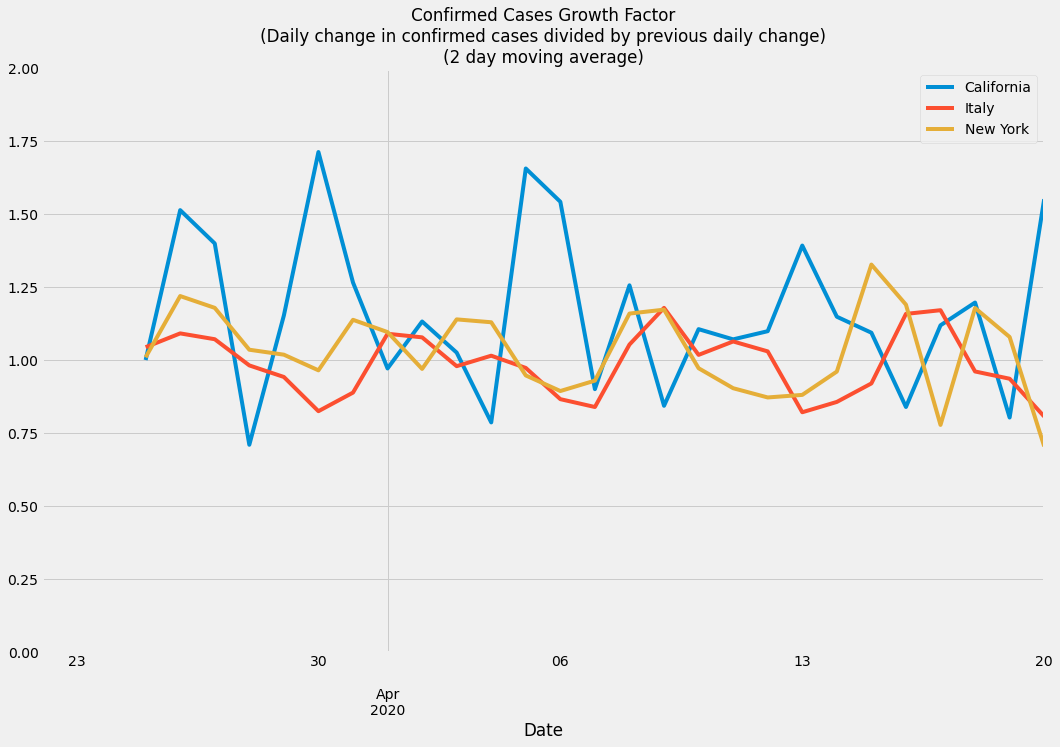

In [34]:
# graph the growth factors
window = 2
ax = tempdf.loc[start_date:,location].diff().pct_change().add(1).rolling(window).mean().plot()
ax.set_ylim(ymin=0, ymax=2)
ax.set_title("Confirmed Cases Growth Factor\n(Daily change in confirmed cases divided by previous daily change)\n({} day moving average)".format(window), fontsize='large')
fig = ax.get_figure()
fig.savefig('growth_factors.png')